# 📋 ATML PA4 - Task 4.2: Implementing SCAFFOLD

In this task, we will use our modified `federated_learning.py` framework to run the **SCAFFOLD** algorithm. SCAFFOLD is designed to correct for 'client drift' in non-IID settings by using control variates.

**Goal:** Compare SCAFFOLD against FedAvg (our baseline) and FedProx on both mildly and highly heterogeneous (non-IID) datasets. We expect SCAFFOLD to show significant gains, especially in the highly non-IID (alpha=0.1) scenario.

## **Part 1: Environment Setup**

### **1.1. Imports and Configuration**

First, we import all necessary libraries and our functions from `federated_learning.py`. We also define the main configuration parameters for the experiments.

In [1]:
# ============================================
# 📦 Imports and Environment Setup
# ============================================
import json
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

module_path = os.path.abspath(os.path.join(os.getcwd(), "../../FedAvg"))

if module_path not in sys.path:
    print(f"Adding path: {module_path}")
    sys.path.append(module_path)
else:
    print(f"Path already in sys.path: {module_path}")
# -----------------------------------------

try:
    from federated_learning import (federated_train,
                                    load_cifar10_noniid_dirichlet)

    print("Successfully imported federated_learning module.")
except ImportError as e:
    print(f"Error: 'federated_learning.py' not found.")
    print(f"Searched in path: {module_path}")
    print(f"Original error: {e}")
    # sys.exit(1) # This might stop the notebook kernel

# ============================================
# ⚙️ Main Configuration
# ============================================
print("Configuring experiment...")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

NUM_CLIENTS = 10
NUM_ROUNDS = 50
LEARNING_RATE = 0.01
BATCH_SIZE = 32
SEED = 42

# ============================================
# ⚙️ Control Flag
# ============================================
FORCE_RETRAIN = False  # Set to True to re-run all training
print(f"FORCE_RETRAIN set to: {FORCE_RETRAIN}")

Adding path: /root/IbsATML/FedAvg
Successfully imported federated_learning module.
Configuring experiment...
Using device: cuda
FORCE_RETRAIN set to: False


### **1.2. Directory Setup**

We create directories specific to Task 4.2.

In [2]:
# ============================================
# 📂 Directory Setup
# ============================================
PLOT_DIR = "plots"
JSON_DIR = "json_results"
MODEL_DIR = "pth_models"

os.makedirs(PLOT_DIR, exist_ok=True)
os.makedirs(JSON_DIR, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)

print(f"Results will be saved in: {JSON_DIR}")
print(f"Plots will be saved in: {PLOT_DIR}")
print(f"Models will be saved in: {MODEL_DIR}")

Results will be saved in: json_results
Plots will be saved in: plots
Models will be saved in: pth_models


## **Part 2: Experiment Configuration**

### **2.1. Define Experiment Scenarios**

We define our experiments:
1.  **FedAvg:** `mu=0`, `use_scaffold=False`
2.  **FedProx:** `mu=0.01` (a reasonable value from Task 4.1), `use_scaffold=False`
3.  **SCAFFOLD:** `mu=0`, `use_scaffold=True`

In [3]:
# ============================================
# 🔬 Experiment Definitions
# ============================================

# Define the different algorithms to test
experiments = {
    "FedAvg_baseline": {"mu": 0.0, "use_scaffold": False},
    "FedProx_mu0.01": {"mu": 0.01, "use_scaffold": False},
    "SCAFFOLD": {"mu": 0.0, "use_scaffold": True},
}

# Define the heterogeneity scenarios (same as Task 4.1)
heterogeneity_levels = {
    "Mild_Heterogeneity": {"alpha": 100, "K": 5},  # Nearly IID
    "High_Heterogeneity": {"alpha": 0.1, "K": 5},  # Highly non-IID
}

# Store all results in this dictionary
all_results = {}

print("Defined experiment scenarios:")
print(f"Heterogeneity levels: {list(heterogeneity_levels.keys())}")
print(f"Algorithms: {list(experiments.keys())}")

Defined experiment scenarios:
Heterogeneity levels: ['Mild_Heterogeneity', 'High_Heterogeneity']
Algorithms: ['FedAvg_baseline', 'FedProx_mu0.01', 'SCAFFOLD']


## **Part 3: Main Experiment Loop**

We loop through each heterogeneity level, load the data, and then run all three algorithms (FedAvg, FedProx, SCAFFOLD) on that same data split for a fair comparison.

We use `client_fraction=1.0` and `K=5` as specified.

In [4]:
# ============================================
# 🚀 Main Experiment Loop
# ============================================

for het_name, het_config in heterogeneity_levels.items():
    alpha = het_config["alpha"]
    K = het_config["K"]

    # Check if results already exist
    json_name = f"results_{het_name}.json"
    json_path = os.path.join(JSON_DIR, json_name)

    if os.path.exists(json_path) and not FORCE_RETRAIN:
        print(f"\n{'='*70}")
        print(f"📂 Loading existing results for: {het_name}")
        print(f"{'='*70}\n")

        with open(json_path, "r") as f:
            het_results = json.load(f)

        all_results[het_name] = het_results
        print(f"✅ Loaded {len(het_results)} experiment results from {json_path}")
        continue  # Skip to next heterogeneity level

    # If we reach here, we need to train
    print(f"\n{'='*70}")
    print(f"🔥 Running experiments for: {het_name} (α={alpha}, K={K})")
    print(f"{'='*70}\n")

    # 1. Create non-IID data ONCE for this heterogeneity level
    print(f"Loading non-IID data (alpha={alpha})...")
    train_loaders, test_loader, client_sizes = load_cifar10_noniid_dirichlet(
        num_clients=NUM_CLIENTS, alpha=alpha, batch_size=BATCH_SIZE, seed=SEED
    )
    print("Data loaded.")

    het_results = {}

    # 2. Loop through each algorithm and run training
    for exp_name, exp_config in experiments.items():
        mu = exp_config["mu"]
        use_scaffold = exp_config["use_scaffold"]

        print(f"\n--- Running: {exp_name} (μ={mu}, SCAFFOLD={use_scaffold}) ---")

        model, history = federated_train(
            num_clients=NUM_CLIENTS,
            num_rounds=NUM_ROUNDS,
            local_epochs=K,
            client_fraction=1.0,  # Full client participation
            lr=LEARNING_RATE,
            batch_size=BATCH_SIZE,
            device=device,
            seed=SEED,
            mu=mu,  # Pass mu for FedProx
            use_scaffold=use_scaffold,  # Pass flag for SCAFFOLD
            train_loaders=train_loaders,  # Use the pre-loaded non-IID data
            test_loader=test_loader,
            client_sizes=client_sizes,
        )

        het_results[exp_name] = history

        # 3. Save model checkpoint
        model_name = f"model_{het_name}_{exp_name}.pth"
        model_path = os.path.join(MODEL_DIR, model_name)
        torch.save(model.state_dict(), model_path)
        print(f"Saved model to {model_path}")

    # 4. Store results for this heterogeneity level
    all_results[het_name] = het_results

    # 5. Save results JSON after each heterogeneity level is complete
    with open(json_path, "w") as f:
        json.dump(het_results, f, indent=4)
    print(f"\n💾 Saved results for {het_name} to {json_path}")


print("\n" + "=" * 70)
print("✅ All experiments complete.")
print("=" * 70)


📂 Loading existing results for: Mild_Heterogeneity

✅ Loaded 3 experiment results from json_results/results_Mild_Heterogeneity.json

📂 Loading existing results for: High_Heterogeneity

✅ Loaded 3 experiment results from json_results/results_High_Heterogeneity.json

✅ All experiments complete.


## **Part 4: Plotting and Analysis**

### **4.1. Generate Comparison Plots**

We now plot the results. For each heterogeneity level, we create a side-by-side comparison of **Test Accuracy** and **Client Drift** for all algorithms.

Generating comparison plots...
Saved plot to plots/plot_Mild_Heterogeneity_comparison.png


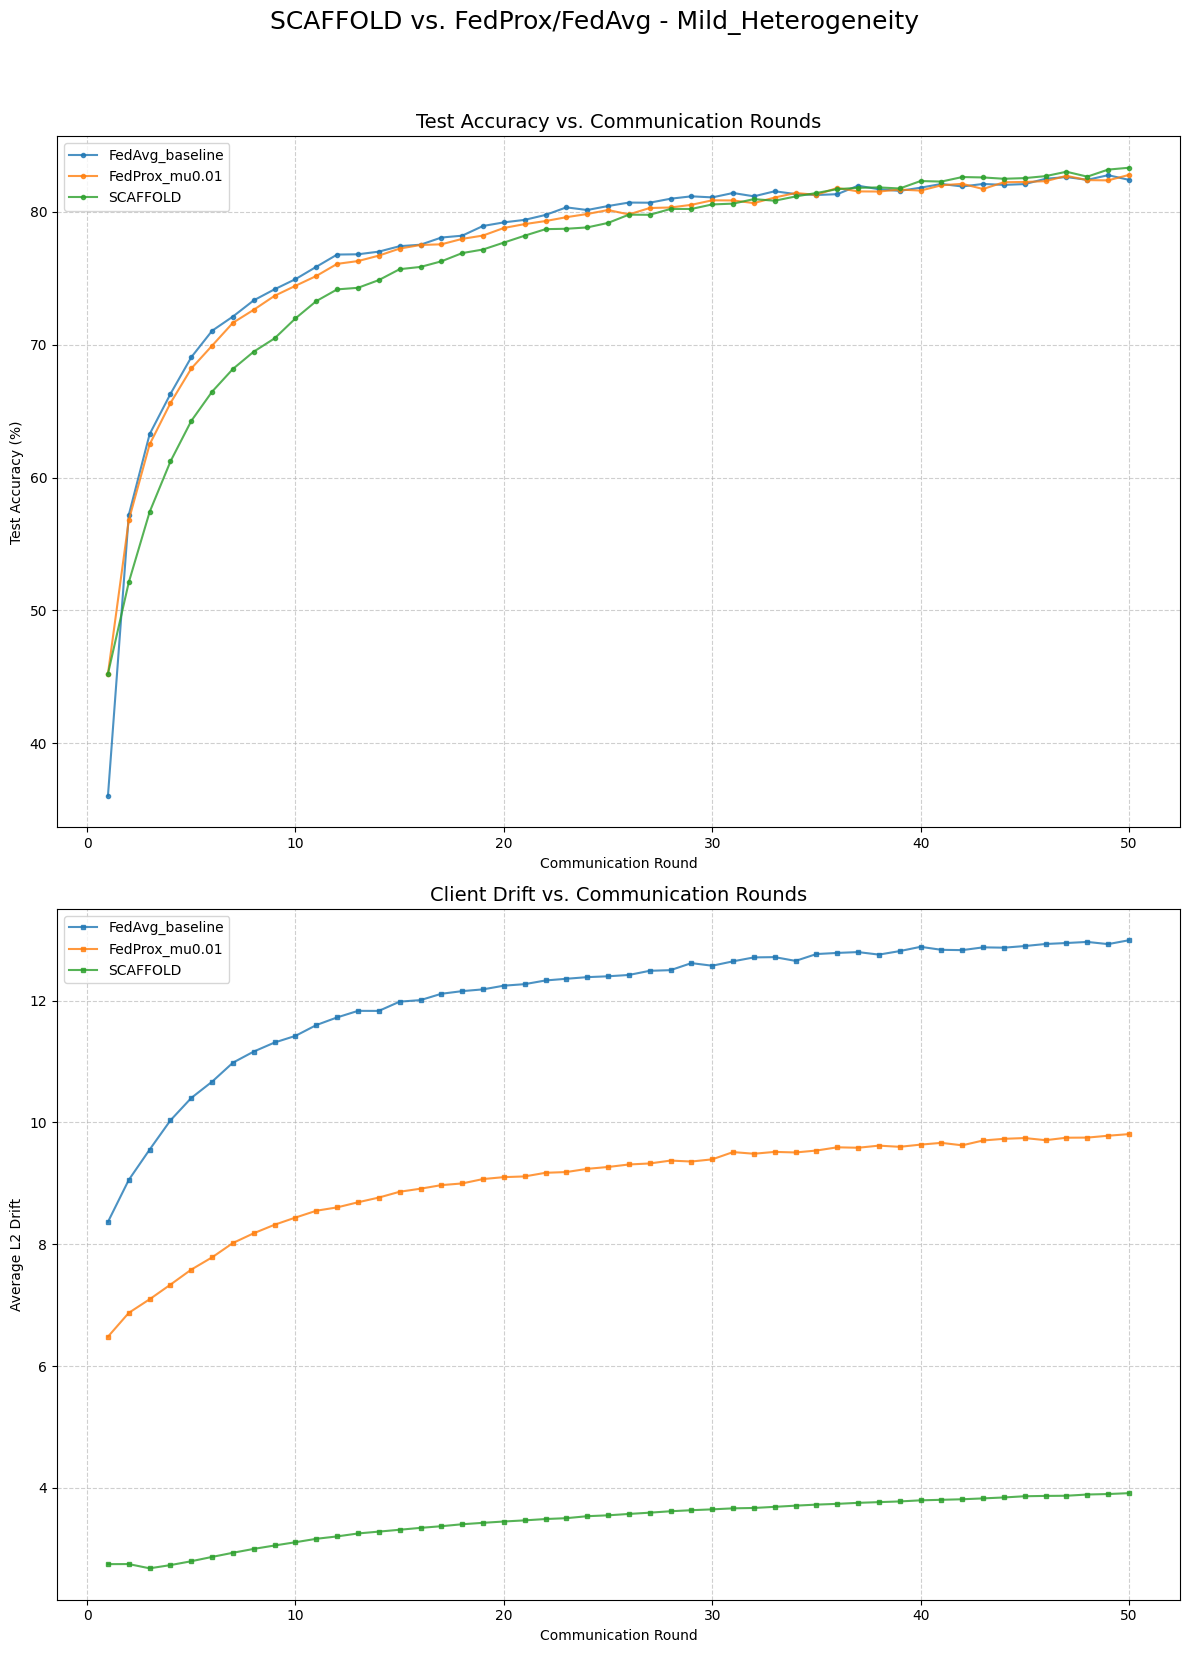

Saved plot to plots/plot_High_Heterogeneity_comparison.png


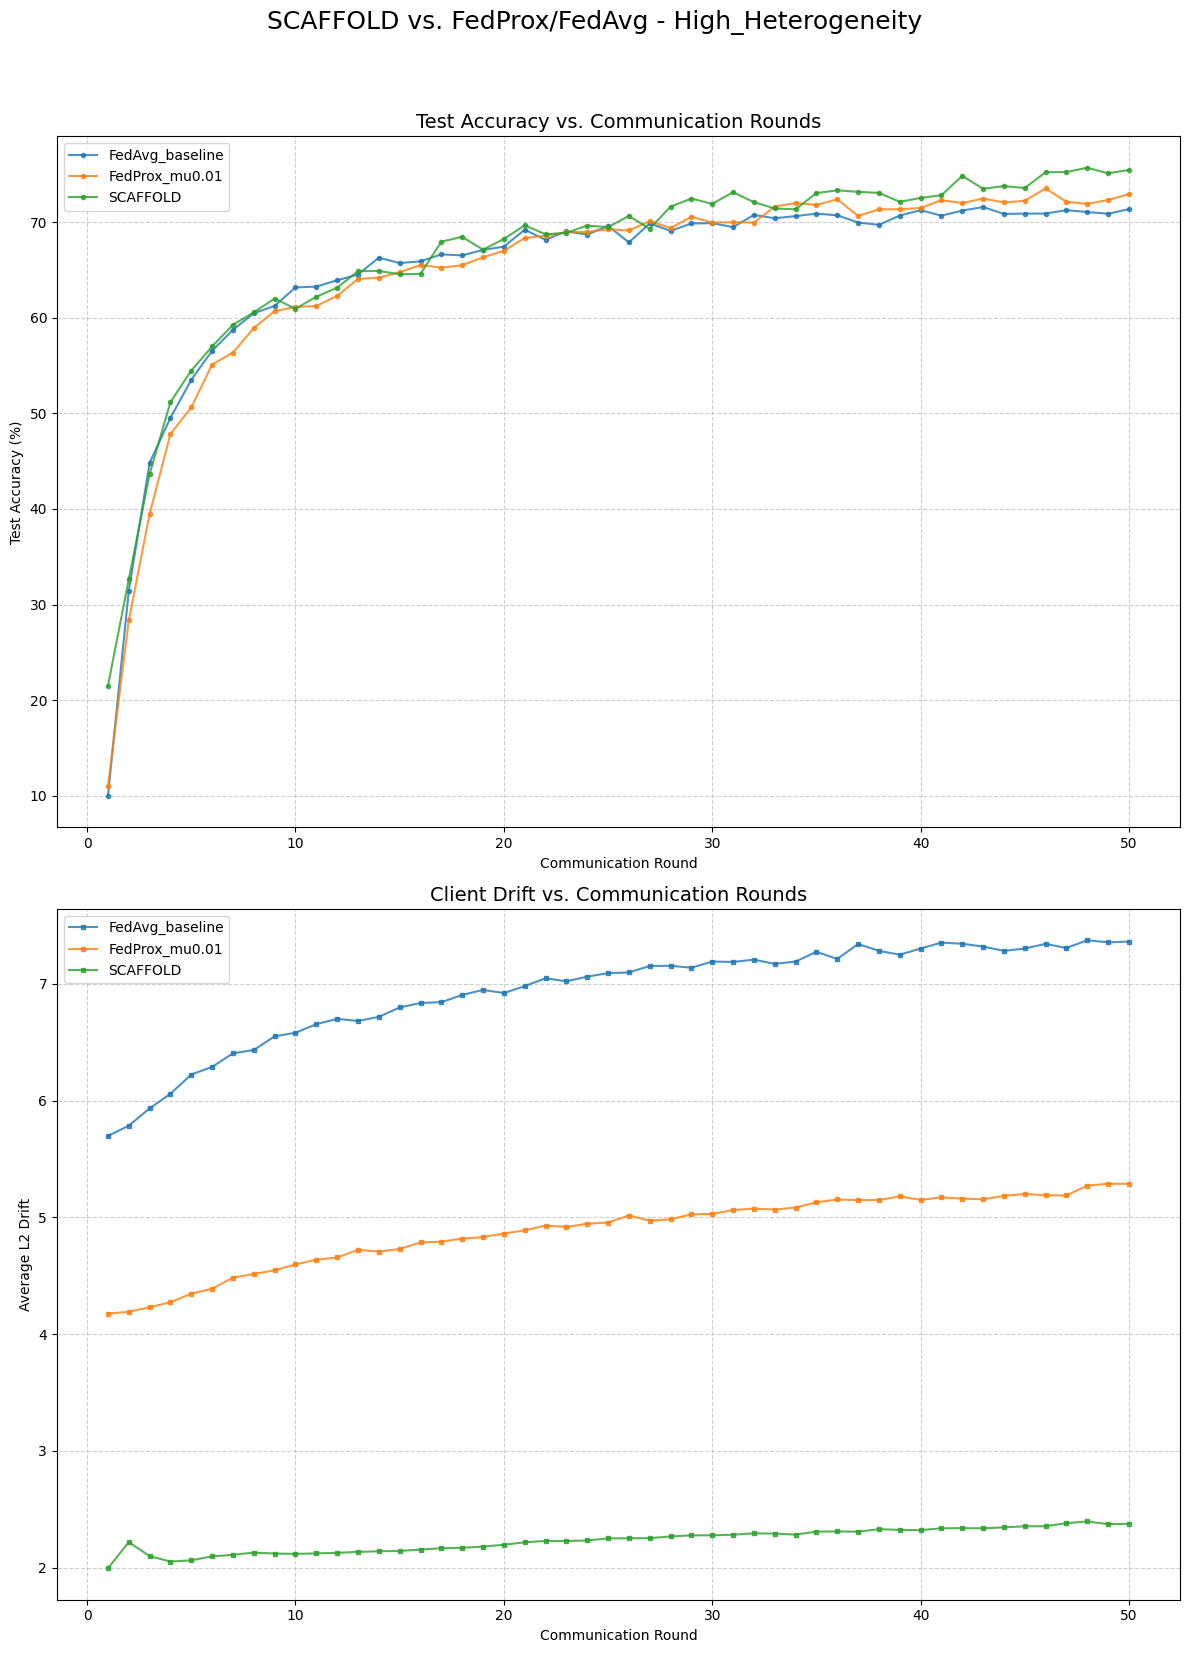

In [5]:
# ============================================
# 📊 Plotting Results
# ============================================
print("Generating comparison plots...")

for het_name in heterogeneity_levels.keys():
    fig, axes = plt.subplots(2, 1, figsize=(12, 16))
    fig.suptitle(f"SCAFFOLD vs. FedProx/FedAvg - {het_name}", fontsize=18, y=1.03)

    if het_name not in all_results:
        print(f"Skipping plot for {het_name}, no results found.")
        continue

    results = all_results[het_name]

    # --- Plot 1: Test Accuracy ---
    axes[0].set_title("Test Accuracy vs. Communication Rounds", fontsize=14)
    axes[0].set_xlabel("Communication Round")
    axes[0].set_ylabel("Test Accuracy (%)")

    for exp_name, history in results.items():
        axes[0].plot(
            history["rounds"],
            history["test_acc"],
            label=exp_name,
            marker="o",
            markersize=3,
            alpha=0.8,
        )

    axes[0].legend()
    axes[0].grid(True, linestyle="--", alpha=0.6)

    # --- Plot 2: Client Drift ---
    axes[1].set_title("Client Drift vs. Communication Rounds", fontsize=14)
    axes[1].set_xlabel("Communication Round")
    axes[1].set_ylabel("Average L2 Drift")

    for exp_name, history in results.items():
        axes[1].plot(
            history["rounds"],
            history["client_drift"],
            label=exp_name,
            marker="s",
            markersize=3,
            alpha=0.8,
        )

    axes[1].legend()
    axes[1].grid(True, linestyle="--", alpha=0.6)

    # --- Save and Show Plot ---
    plt.tight_layout()
    plot_name = f"plot_{het_name}_comparison.png"
    plot_path = os.path.join(PLOT_DIR, plot_name)
    plt.savefig(plot_path, dpi=300, bbox_inches="tight")
    print(f"Saved plot to {plot_path}")
    plt.show()

### **4.2. Create Summary Table**

Finally, we'll generate a summary table to compare the final performance metrics.

In [6]:
# ============================================
# 📈 Analysis & Summary Table
# ============================================
print("\n" + "=" * 70)
print("📊 Summary Table")
print("=" * 70)

summary_data = []

for het_name, results in all_results.items():
    for exp_name, history in results.items():
        summary_data.append(
            {
                "Scenario": het_name,
                "Algorithm": exp_name,
                "μ": experiments[exp_name]["mu"],
                "SCAFFOLD": experiments[exp_name]["use_scaffold"],
                "Final Accuracy (%)": history["test_acc"][-1],
                "Final Drift": history["client_drift"][-1],
                "Avg Acc (last 10r)": np.mean(history["test_acc"][-10:]),
                "Std Dev (last 10r)": np.std(history["test_acc"][-10:]),
            }
        )

summary_df = pd.DataFrame(summary_data)

# Display the table in markdown format for easy copy-pasting
print(summary_df.to_markdown(index=False, floatfmt=".3f"))

print("\n--- Analysis complete. ---")


📊 Summary Table
| Scenario           | Algorithm       |     μ | SCAFFOLD   |   Final Accuracy (%) |   Final Drift |   Avg Acc (last 10r) |   Std Dev (last 10r) |
|:-------------------|:----------------|------:|:-----------|---------------------:|--------------:|---------------------:|---------------------:|
| Mild_Heterogeneity | FedAvg_baseline | 0.000 | False      |               82.390 |        12.989 |               82.272 |                0.269 |
| Mild_Heterogeneity | FedProx_mu0.01  | 0.010 | False      |               82.760 |         9.807 |               82.267 |                0.297 |
| Mild_Heterogeneity | SCAFFOLD        | 0.000 | True       |               83.300 |         3.914 |               82.718 |                0.311 |
| High_Heterogeneity | FedAvg_baseline | 0.000 | False      |               71.360 |         7.364 |               71.067 |                0.263 |
| High_Heterogeneity | FedProx_mu0.01  | 0.010 | False      |               72.930 |         5.288 | 